# Detecting Payment Card Fraud

The payment fraud data set was downloaded from Kaggle. This has features and labels for thousands of credit card transactions, each of which is labeled as fraudulent or valid. In this notebook, we'd like to train a model based on the features of these transactions so that we can predict risky or fraudulent transactions in the future.

Since we have true labels to aim for, we'll take a supervised learning approach and train a binary classifier to sort data into one of our two transaction classes: fraudulent or valid. We'll train a model on training data and see how well it generalizes on some test data. We are using AWS SageMaker services to work on this data set.

The notebook will be broken down into a few steps:

1. Loading and exploring the data
2. Splitting the data into train/test sets
3. Defining and training a LinearLearner, binary classifier
3. Making improvements on the model but tuning the models hyper parameters
4. Evaluating and comparing model test performance after adjusting the class imbalance and recall

In [1]:
import io
import os
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd 

import boto3
import sagemaker
from sagemaker import get_execution_role

%matplotlib inline

I'm storing my SageMaker variables in the next cell:

1. sagemaker_session: The SageMaker session we'll use for training models.
2. bucket: The name of the default S3 bucket that we'll use for data storage.
3. role: The IAM role that defines our data and model permissions.

In [2]:
# sagemaker session, role
sagemaker_session = sagemaker.Session()
role = sagemaker.get_execution_role()

# S3 bucket name
bucket = sagemaker_session.default_bucket()

In [5]:
# read in the csv file
local_data = 'creditcard.csv'

# print out some data
df = pd.read_csv(local_data)
print('Data shape (rows, cols): ', df.shape)
print()
df.head()

Data shape (rows, cols):  (284807, 31)



,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


Text(0, 0.5, 'Frequency')

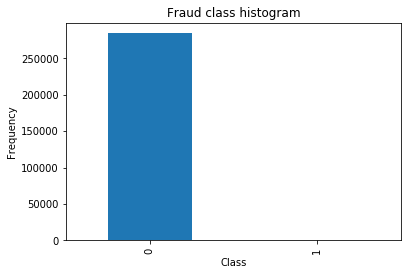

In [6]:
count_classes = pd.value_counts(df['Class'], sort = True).sort_index()
count_classes.plot(kind = 'bar')
plt.title("Fraud class histogram")
plt.xlabel("Class")
plt.ylabel("Frequency")

Clearly the data is totally unbalanced! 
Lets find how the percentage of fraudulent data

In [8]:
print('Valid', round(df['Class'].value_counts()[0]/len(df) * 100,2), '% of the dataset')
print('Frauds', round(df['Class'].value_counts()[1]/len(df) * 100,2), '% of the dataset')

Valid 99.83 % of the dataset
Frauds 0.17 % of the dataset


In [21]:
# split into train/test
def train_test_split(df, train_frac= 0.7, seed=1):
    
    # convert the df into a matrix for ease of splitting
    df_matrix = df.values
    
    # shuffle the data
    np.random.seed(seed)
    np.random.shuffle(df_matrix)
    
    # split the data
    train_size = int(df_matrix.shape[0] * train_frac)
    # features are all but last column
    train_features  = df_matrix[:train_size, :-1]
    # class labels *are* last column
    train_labels = df_matrix[:train_size, -1]
    # test data
    test_features = df_matrix[train_size:, :-1]
    test_labels = df_matrix[train_size:, -1]
    
    return (train_features, train_labels), (test_features, test_labels)

In [22]:
# get train/test data
(train_features, train_labels), (test_features, test_labels) = train_test_split(df, train_frac=0.7)

print("Number transactions train dataset: ", len(train_features))
print("Number transactions test dataset: ", len(test_features))
print("Total number of transactions: ", len(train_features)+len(test_features))

Number transactions train dataset:  199364
Number transactions test dataset:  85443
Total number of transactions:  284807


## Modeling

We'll define and train the SageMaker, built-in algorithm, LinearLearner. Since its a classification problem we use binary classifier as hyper parameter

In [23]:
# import LinearLearner
from sagemaker import LinearLearner

# specify an output path
prefix = 'creditcard'
output_path = 's3://{}/{}'.format(bucket, prefix)

# instantiate LinearLearner
linear = LinearLearner(role=role,
                       train_instance_count=1, 
                       train_instance_type='ml.c4.xlarge',
                       predictor_type='binary_classifier',
                       output_path=output_path,
                       sagemaker_session=sagemaker_session,
                       epochs=15)

In [24]:
# convert features/labels to numpy
train_x_np = train_features.astype('float32')
train_y_np = train_labels.astype('float32')

# create RecordSet
formatted_train_data = linear.record_set(train_x_np, labels=train_y_np)

In [25]:
%%time 
# train the estimator on formatted training data
linear.fit(formatted_train_data)

'get_image_uri' method will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.
'get_image_uri' method will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.


2020-07-09 22:54:33 Starting - Starting the training job...
2020-07-09 22:54:35 Starting - Launching requested ML instances.........
2020-07-09 22:56:07 Starting - Preparing the instances for training...
2020-07-09 22:57:01 Downloading - Downloading input data......
2020-07-09 22:57:54 Training - Training image download completed. Training in progress.Docker entrypoint called with argument(s): train
Running default environment configuration script
[07/09/2020 22:57:58 INFO 140209308866368] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-input.json: {u'loss_insensitivity': u'0.01', u'epochs': u'15', u'feature_dim': u'auto', u'init_bias': u'0.0', u'lr_scheduler_factor': u'auto', u'num_calibration_samples': u'10000000', u'accuracy_top_k': u'3', u'_num_kv_servers': u'auto', u'use_bias': u'true', u'num_point_for_scaler': u'10000', u'_log_level': u'info', u'quantile': u'0.5', u'bias_lr_mult': u'auto', u'lr_scheduler_step': u'auto', u'ini

In [26]:
%%time 
# deploy and create a predictor
linear_predictor = linear.deploy(initial_instance_count=1, instance_type='ml.t2.medium')

Parameter image will be renamed to image_uri in SageMaker Python SDK v2.


-----------------!CPU times: user 310 ms, sys: 17 ms, total: 327 ms
Wall time: 8min 32s


## Evaluating the Model
Once your model is deployed, you can see how it performs when applied to the test data.

According to the deployed predictor documentation, this predictor expects an ndarray of input features and returns a list of Records.

In [27]:
# code to evaluate the endpoint on test data
# returns a variety of model metrics
def evaluate(predictor, test_features, test_labels, verbose=True):
    """
    Evaluate a model on a test set given the prediction endpoint.  
    Return binary classification metrics.
    :param predictor: A prediction endpoint
    :param test_features: Test features
    :param test_labels: Class labels for test data
    :param verbose: If True, prints a table of all performance metrics
    :return: A dictionary of performance metrics.
    """
    
    # We have a lot of test data, so we'll split it into batches of 100
    # split the test data set into batches and evaluate using prediction endpoint    
    prediction_batches = [predictor.predict(batch) for batch in np.array_split(test_features, 100)]
    
    # LinearLearner produces a `predicted_label` for each data point in a batch
    # get the 'predicted_label' for every point in a batch
    test_preds = np.concatenate([np.array([x.label['predicted_label'].float32_tensor.values[0] for x in batch]) 
                                 for batch in prediction_batches])
    
    # calculate true positives, false positives, true negatives, false negatives
    tp = np.logical_and(test_labels, test_preds).sum()
    fp = np.logical_and(1-test_labels, test_preds).sum()
    tn = np.logical_and(1-test_labels, 1-test_preds).sum()
    fn = np.logical_and(test_labels, 1-test_preds).sum()
    
    # calculate binary classification metrics
    recall = tp / (tp + fn)
    precision = tp / (tp + fp)
    accuracy = (tp + tn) / (tp + fp + tn + fn)
    
    # printing a table of metrics
    if verbose:
        print(pd.crosstab(test_labels, test_preds, rownames=['actual (row)'], colnames=['prediction (col)']))
        print("\n{:<11} {:.3f}".format('Recall:', recall))
        print("{:<11} {:.3f}".format('Precision:', precision))
        print("{:<11} {:.3f}".format('Accuracy:', accuracy))
        print()
        
    return {'TP': tp, 'FP': fp, 'FN': fn, 'TN': tn, 
            'Precision': precision, 'Recall': recall, 'Accuracy': accuracy}

In [28]:
print('Metrics for simple, LinearLearner.\n')

# get metrics for linear predictor
metrics = evaluate(linear_predictor, 
                   test_features.astype('float32'), 
                   test_labels, 
                   verbose=True) # verbose means we'll print out the metrics

Metrics for simple, LinearLearner.

prediction (col)    0.0  1.0
actual (row)                
0.0               85269   33
1.0                  32  109

Recall:     0.773
Precision:  0.768
Accuracy:   0.999



We can see that this model gets a very high accuracy of 99.9% ! But it still misclassifies about 30 (each) of our valid and fraudulent cases, which results in much lower values for recall and precision. Now as a card company we want to minimize the number of allowed fraudulent transaction since the cost of allowing a fraudulant transaction is much higher

Next, let's delete this endpoint and discuss ways to improve this model.

In [29]:
# Deletes a precictor.endpoint
def delete_endpoint(predictor):
        try:
            boto3.client('sagemaker').delete_endpoint(EndpointName=predictor.endpoint)
            print('Deleted {}'.format(predictor.endpoint))
        except:
            print('Already deleted: {}'.format(predictor.endpoint))

In [30]:
# delete the predictor endpoint 
delete_endpoint(linear_predictor)

Deleted linear-learner-2020-07-09-22-54-33-562


# Hyper Parameter Tuning

Now to improve out model for our use case we can carry 2 things out

### 1. Class Imbalance
As we know the number of fraudulent data is much smaller in number (0.17%) we need to reduce this overfitting. We solve it by balancing our data as a hyper parameter

### 2. Target Recall
Since we want to reduce our false positives we will set a target recall precision as a hyper parameter to 0.9.

In [31]:
# instantiate a LinearLearner
# tune the model for a higher recall
linear_tuned = LinearLearner(role=role,
                              train_instance_count=1, 
                              train_instance_type='ml.c4.xlarge',
                              predictor_type='binary_classifier',
                              output_path=output_path,
                              sagemaker_session=sagemaker_session,
                              epochs=15,
                              binary_classifier_model_selection_criteria='precision_at_target_recall', # target recall
                              target_recall=0.9, # 90% recall
                              positive_example_weight_mult='balanced') 

In [32]:
%%time 
# train the estimator on formatted training data
linear_tuned.fit(formatted_train_data)

'get_image_uri' method will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.
'get_image_uri' method will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.


2020-07-09 23:12:57 Starting - Starting the training job...
2020-07-09 23:12:59 Starting - Launching requested ML instances......
2020-07-09 23:14:03 Starting - Preparing the instances for training......
2020-07-09 23:15:09 Downloading - Downloading input data...
2020-07-09 23:15:51 Training - Training image download completed. Training in progress.Docker entrypoint called with argument(s): train
Running default environment configuration script
[07/09/2020 23:15:54 INFO 139981486925632] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-input.json: {u'loss_insensitivity': u'0.01', u'epochs': u'15', u'feature_dim': u'auto', u'init_bias': u'0.0', u'lr_scheduler_factor': u'auto', u'num_calibration_samples': u'10000000', u'accuracy_top_k': u'3', u'_num_kv_servers': u'auto', u'use_bias': u'true', u'num_point_for_scaler': u'10000', u'_log_level': u'info', u'quantile': u'0.5', u'bias_lr_mult': u'auto', u'lr_scheduler_step': u'auto', u'init_m

In [35]:
%%time 
# deploy and create a predictor
balanced_predictor = linear_tuned.deploy(initial_instance_count=1, instance_type='ml.t2.medium')

Parameter image will be renamed to image_uri in SageMaker Python SDK v2.


-------------------!CPU times: user 345 ms, sys: 8.62 ms, total: 354 ms
Wall time: 9min 32s


In [36]:
print('Metrics for tuned, LinearLearner.\n')

# get metrics for tuned predictor
metrics = evaluate(balanced_predictor, 
                   test_features.astype('float32'), 
                   test_labels, 
                   verbose=True)

Metrics for tuned, LinearLearner.

prediction (col)    0.0   1.0
actual (row)                 
0.0               84277  1025
1.0                  12   129

Recall:     0.915
Precision:  0.112
Accuracy:   0.988



Clearly accuracy has been compromised but we have a better result in terms of our business case. Hence objective achieved in terms of lower false negative

In [37]:
# delete the predictor endpoint 
delete_endpoint(balanced_predictor)

Deleted linear-learner-2020-07-09-23-12-57-493
